In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

import lightgbm as lgb
from lightgbm import LGBMRegressor

import json

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.inspection import permutation_importance

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import yellowbrick.model_selection as ms

In [2]:
csv_training_files = ['../Datasets/landsat_features_more_bands_train.csv',
                          '../Datasets/terraclimate_features_more_bands_training.csv',
                          '../Datasets/nasa_precip_features_training.csv',
                          '../Datasets/soil_use_data_rounded_in_packs_training.csv',
                          '../Datasets/nasa_terrain_features_rounded_in_packs_training.csv',
                          '../Datasets/water_quality_training_dataset.csv']

target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

drop_features = []#['pct_agri', 'pct_water', 'pct_wetlands', 'curvature', 'pct_others', 'elevation', 'pct_natural', 'slope', 'pct_urban']
columns_to_drop_from_features = ["Latitude", "Longitude", "Sample Date"] + drop_features

dataHandler = DataOrganizer(target_columns)
dataHandler.load_training_data(csv_training_files, columns_to_drop_from_features, scale=True)
dataHandler.get_feature_columns()

['nir',
 'green',
 'swir16',
 'swir22',
 'coastal',
 'blue',
 'red',
 'lwir11',
 'NDMI',
 'MNDWI',
 'Clorfilia',
 'Turbidity',
 'NDTI',
 'NDVI',
 'q',
 'ppt',
 'pet',
 'soil',
 'pdsi',
 'tmax',
 'tmin',
 'Saline_Index',
 'Runoff_Ratio',
 'Chemical_Solubility',
 'rain_7d_nasa',
 'rain_3d_nasa',
 'rain_12d_nasa',
 'pct_agri',
 'pct_urban',
 'pct_natural',
 'pct_water',
 'pct_wetlands',
 'pct_others',
 'elevation',
 'slope',
 'curvature',
 'month_sin']

In [3]:


train_splits = get_location_train_test_split(dataHandler, test_size = 0.2)

X_train_alkalinity = train_splits['Total Alkalinity']['X_train']
X_test_alkalinity = train_splits['Total Alkalinity']['X_test']
Y_train_alkalinity = train_splits['Total Alkalinity']['Y_train']
Y_test_alkalinity = train_splits['Total Alkalinity']['Y_test']

X_train_electrical = train_splits['Electrical Conductance']['X_train']
X_test_electrical = train_splits['Electrical Conductance']['X_test']
Y_train_electrical = train_splits['Electrical Conductance']['Y_train']
Y_test_electrical = train_splits['Electrical Conductance']['Y_test']

X_train_phosphorus = train_splits['Dissolved Reactive Phosphorus']['X_train']
X_test_phosphorus = train_splits['Dissolved Reactive Phosphorus']['X_test']
Y_train_phosphorus = train_splits['Dissolved Reactive Phosphorus']['Y_train']
Y_test_phosphorus = train_splits['Dissolved Reactive Phosphorus']['Y_test']

X_train_alkalinity



✅ Split concluído: 7395 amostras para treino, 1924 para teste.


,nir,green,swir16,swir22,coastal,blue,red,lwir11,NDMI,MNDWI,...,pct_agri,pct_urban,pct_natural,pct_water,pct_wetlands,pct_others,elevation,slope,curvature,month_sin
0,-0.905689,0.289543,-1.626557,-1.395962,-0.088603,0.026128,0.501105,-0.005760,2.170273,3.505874,...,-0.800066,-0.329943,-2.719249,3.745750,-0.070432,6.398711,-1.464718,1.344379,1.086239,0.723365
1,0.938320,-0.193153,-0.021510,-0.366148,-0.088603,-0.163629,-0.343609,-0.005760,1.357020,-0.383227,...,1.574208,-0.329943,-0.836968,-0.266969,-0.070432,-0.196023,1.112806,-0.456177,-0.097975,0.723365
2,0.240314,0.107889,1.098367,0.909078,-0.088603,0.014186,0.438947,-0.005760,-1.415426,-1.135432,...,0.980639,-0.329943,-0.836968,-0.266969,-0.070432,-0.196023,1.112806,-0.456177,-1.282189,0.723365
3,2.320366,1.880561,1.633472,2.468742,-0.088603,1.610904,1.731107,-0.005760,0.484053,0.824948,...,-0.800066,4.152178,-1.307538,-0.266969,-0.070432,-0.196023,0.898012,-0.456177,1.086239,0.723365
4,0.701708,-0.205374,-0.307870,-0.693480,-0.088603,-0.116518,-0.124216,-0.005760,1.578182,0.004423,...,0.980639,-0.329943,-0.366398,-0.266969,-0.070432,-0.196023,0.898012,-0.006038,-1.282189,0.723365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9312,-0.256573,-0.142464,-0.547872,-0.591870,-0.088603,-0.085842,-0.247168,-0.005760,0.598358,0.512718,...,-0.800066,-0.329943,0.574743,3.745750,-0.070432,-0.196023,0.683219,-0.006038,-1.282189,0.026761
9313,-0.004281,-0.141564,0.492799,0.548696,0.240176,-0.072037,-0.127596,3.302728,-0.897653,-0.934633,...,-0.800066,-0.329943,1.045314,-0.266969,-0.070432,-0.196023,0.468425,-0.456177,-0.097975,0.026761
9315,0.363609,-0.001592,0.852405,1.088038,0.201714,-0.029967,0.016649,2.978710,-0.876938,-1.074591,...,1.574208,-0.329943,-0.836968,-0.266969,-0.070432,-0.196023,1.112806,-0.456177,-0.097975,0.026761
9317,0.102765,0.193056,1.216514,1.444729,-0.088603,0.097232,0.328390,-0.005760,-1.790264,-1.106832,...,0.387071,-0.329943,0.104173,-0.266969,-0.070432,-0.196023,0.683219,-0.006038,-0.097975,0.026761


## XGBoost

In [19]:
model_params = {
    'objective' :'reg:squarederror',
    'booster':'dart',
    'learning_rate' : 0.05, # bom
    'max_depth' : 6, # bom, muda comforme adicionar dados 
    'n_estimators' : 100, # bom, muda conforme adicionar dados
    'subsample' : 0.5,
    'colsample_bytree' : 0.6,
    'min_child_weight' : 15.0, ## fixado assim, bom
    'gamma' : 1.5,  ## fixado assim, bom
    'verbosity' : 1,
    'rate_drop' : 0.25, # bom : 0.25
    'skip_drop' : 0.5, # bom : 0.5
    
    'reg_lambda' : 15.0,                # L2 >= 0
    'reg_alpha' : 9.0,
}

model_alcalinity= xgb.XGBRegressor(**model_params)

model_electrical= xgb.XGBRegressor(**model_params)


model_phosphorus= xgb.XGBRegressor(**model_params)

# parametros treino:


In [20]:

model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, Y_test_alkalinity)])

model_electrical.fit(X_train_electrical, Y_train_electrical,
            eval_set=[(X_test_electrical, Y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus,
            eval_set=[(X_test_phosphorus, Y_test_phosphorus)])

[0]	validation_0-rmse:72.11575
[1]	validation_0-rmse:71.52512
[2]	validation_0-rmse:70.33306
[3]	validation_0-rmse:69.80090
[4]	validation_0-rmse:69.22992
[5]	validation_0-rmse:68.48318
[6]	validation_0-rmse:67.82183
[7]	validation_0-rmse:67.53871
[8]	validation_0-rmse:66.93603
[9]	validation_0-rmse:66.34011
[10]	validation_0-rmse:65.64666
[11]	validation_0-rmse:65.31315
[12]	validation_0-rmse:64.98793
[13]	validation_0-rmse:64.62239
[14]	validation_0-rmse:64.06586
[15]	validation_0-rmse:63.87300
[16]	validation_0-rmse:63.50215
[17]	validation_0-rmse:63.42093
[18]	validation_0-rmse:63.35181
[19]	validation_0-rmse:63.23043
[20]	validation_0-rmse:62.95934
[21]	validation_0-rmse:62.91658
[22]	validation_0-rmse:62.88553
[23]	validation_0-rmse:62.81926
[24]	validation_0-rmse:62.75983
[25]	validation_0-rmse:62.27459
[26]	validation_0-rmse:62.21649
[27]	validation_0-rmse:62.15987
[28]	validation_0-rmse:62.09039
[29]	validation_0-rmse:61.97133
[30]	validation_0-rmse:61.60603
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,'dart'
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.6
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabete

## LGBM

In [4]:
model_params = {
    'boosting_type':'gbdt',       # 'gbdt' (tradicional) ou 'dart'
    'n_estimators':250,           # Mais árvores, pois o LGBM é rápido
    'learning_rate':0.03,         # Passo menor para melhor generalização
    'num_leaves':23,              # O mais importante do LGBM (Controle de complexidade) - manter entre 20 e 40
    'max_depth':-1,                # Limita a profundidade para evitar decorar o mapa
    'min_child_samples':20,       # Equivalente ao min_child_weight (evita folhas com poucos dados), overfitting e under
    'min_child_weight': 0.1,     # Evita folhas com poucos dados, overfitting e underfitting
    'subsample':0.7,              # % de dados por árvore
    'colsample_bytree':0.5,       # % de features por árvore (fundamental para o seu caso)
    'reg_alpha':10.0,             # Regularização L1
    'reg_lambda':10.0,            # Regularização L2
    'random_state':42,
    'n_jobs':-1,                  # Usa todos os núcleos do processador
    'importance_type':'gain',      # Mede importância pelo ganho de precisão
    'verbosity': -1,
    
    #boosting_type='dart',
    #drop_rate=0.15,             # % de árvores a dropar
    #skip_drop=0.5,              # Probabilidade de pular o drop
}

model_alcalinity= LGBMRegressor(**model_params)

model_electrical= LGBMRegressor(**model_params)

model_phosphorus= LGBMRegressor(**model_params)

In [5]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity,
            eval_set=[(X_test_alkalinity, Y_test_alkalinity)])

model_electrical.fit(X_train_electrical, Y_train_electrical,
            eval_set=[(X_test_electrical, Y_test_electrical)])

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus,
            eval_set=[(X_test_phosphorus, Y_test_phosphorus)])

,boosting_type,'gbdt'
,num_leaves,23
,max_depth,-1
,learning_rate,0.03
,n_estimators,250
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.1
,min_child_samples,20


## Random Forest

In [16]:
params = {
    'n_estimators':220,           # [100-500] Núm. de árvores. Mais é melhor, mas pesa no PC.
    'max_depth':7,                # [4-10] Profundidade. Mantenha baixo para evitar decorar o mapa.
#    'min_samples_leaf':10,        # [5-50] Mín. de amostras por folha. Ótimo contra overfitting.
    'max_features':0.5,        # ['sqrt', 'log2', 0.5] Quantas colunas cada árvore vê. 
#                                # 'sqrt' força o modelo a não depender só de Tmax/Relevo.
    'bootstrap':True,             # Usa amostras aleatórias dos dados.
    'n_jobs':-1,                  # Usa todos os núcleos do seu processador (muito rápido).
#    'random_state':42,
#    'verbose':0
}

model_alcalinity= RandomForestRegressor(**params)
    
model_electrical= RandomForestRegressor(**params)

model_phosphorus= RandomForestRegressor(**params)


In [17]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity)

model_electrical.fit(X_train_electrical, Y_train_electrical)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",220
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",0.5
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

## Rede Neural

In [585]:
model_alcalinity = Sequential([
    tf.keras.Input(shape=(X_train_electrical.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_electrical = Sequential([
    tf.keras.Input(shape=(X_train_electrical.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_phosphorus = Sequential([
    tf.keras.Input(shape=(X_train_phosphorus.shape[1],)),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dropout(0.05),
    Dense(10, activation="relu"),
    Dense(1, activation="relu")
])

model_alcalinity.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model_electrical.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model_phosphorus.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

In [586]:
model_alcalinity.fit(X_train_alkalinity, Y_train_alkalinity, validation_data=(X_test_alkalinity, Y_test_alkalinity), epochs=30, batch_size=32)
    
model_electrical.fit(X_train_electrical, Y_train_electrical, validation_data=(X_test_electrical, Y_test_electrical), epochs=30, batch_size=32)

model_phosphorus.fit(X_train_phosphorus, Y_train_phosphorus, validation_data=(X_test_phosphorus, Y_test_phosphorus), epochs=30, batch_size=32)

Epoch 1/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7204.8535 - val_loss: 4111.7739
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3872.7002 - val_loss: 3938.9475
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3673.9021 - val_loss: 4165.9595
Epoch 4/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3569.9626 - val_loss: 4257.6182
Epoch 5/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3610.1836 - val_loss: 4074.8533
Epoch 6/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3488.0557 - val_loss: 3934.0332
Epoch 7/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3435.8362 - val_loss: 4107.4829
Epoch 8/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3393.4565 - val_loss: 4197.2100
Epoch 9/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3408.5586 - val_loss: 4241.5171
Epoch 10/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3358.6294 - val_loss: 4215.0415
Epoch 11/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3278.7522 - val_lo

## Selecao de Features

In [21]:
classifier = FeatureClassifier(csv_training_files=csv_training_files)

classifier.define_model(model_alcalinity)

best_features_dict = classifier.classify_features_per_target(feature_to_start='swir22')

print(best_features_dict)

with open('../Signal_Features/best_features_XGBoost.json', 'w', encoding= 'utf-8') as f:
    json.dump(best_features_dict, f, indent=4)


📥 Carregando todos os dados para memória (isso acontece só uma vez)...
✅ Split concluído: 7395 amostras para treino, 1924 para teste.


100%|██████████| 36/36 [00:29<00:00,  1.23it/s]


🏁 Seleção Finalizada para Total Alkalinity
   Features Mantidas: 16/37
   Melhor R²: 0.3509
   Lista: ['swir22', 'green', 'red', 'lwir11', 'NDMI', 'q', 'pet', 'soil', 'pdsi', 'tmax', 'rain_7d_nasa', 'pct_water', 'pct_wetlands', 'pct_others', 'curvature', 'month_sin']


100%|██████████| 36/36 [00:28<00:00,  1.24it/s]


🏁 Seleção Finalizada para Electrical Conductance
   Features Mantidas: 15/37
   Melhor R²: 0.3167
   Lista: ['swir22', 'green', 'coastal', 'blue', 'red', 'NDTI', 'q', 'pet', 'pdsi', 'tmin', 'Runoff_Ratio', 'rain_7d_nasa', 'pct_agri', 'elevation', 'month_sin']


100%|██████████| 36/36 [00:28<00:00,  1.24it/s]

🏁 Seleção Finalizada para Dissolved Reactive Phosphorus
   Features Mantidas: 14/37
   Melhor R²: 0.2543
   Lista: ['swir22', 'green', 'swir16', 'coastal', 'blue', 'lwir11', 'NDMI', 'q', 'pet', 'pdsi', 'Saline_Index', 'rain_12d_nasa', 'slope', 'curvature']
{'Total Alkalinity': ['swir22', 'green', 'red', 'lwir11', 'NDMI', 'q', 'pet', 'soil', 'pdsi', 'tmax', 'rain_7d_nasa', 'pct_water', 'pct_wetlands', 'pct_others', 'curvature', 'month_sin'], 'Electrical Conductance': ['swir22', 'green', 'coastal', 'blue', 'red', 'NDTI', 'q', 'pet', 'pdsi', 'tmin', 'Runoff_Ratio', 'rain_7d_nasa', 'pct_agri', 'elevation', 'month_sin'], 'Dissolved Reactive Phosphorus': ['swir22', 'green', 'swir16', 'coastal', 'blue', 'lwir11', 'NDMI', 'q', 'pet', 'pdsi', 'Saline_Index', 'rain_12d_nasa', 'slope', 'curvature']}


## training

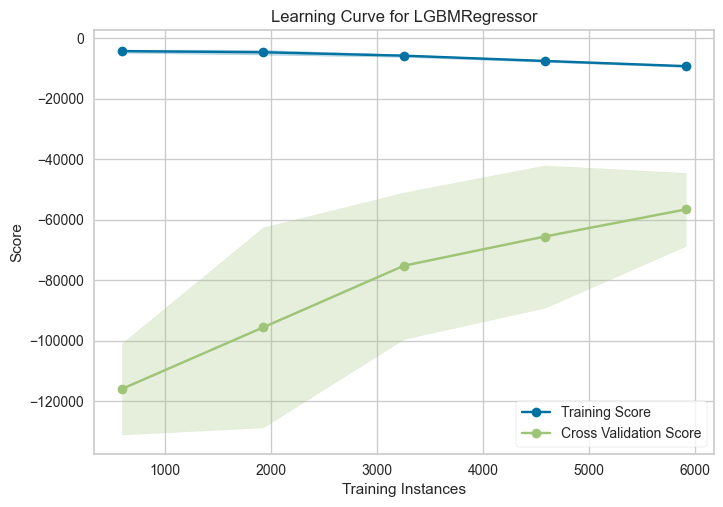

In [38]:
_ = ms.learning_curve(model_electrical, X_train_electrical, Y_train_electrical, scoring='neg_mean_squared_error', cv=5)

<Axes: >

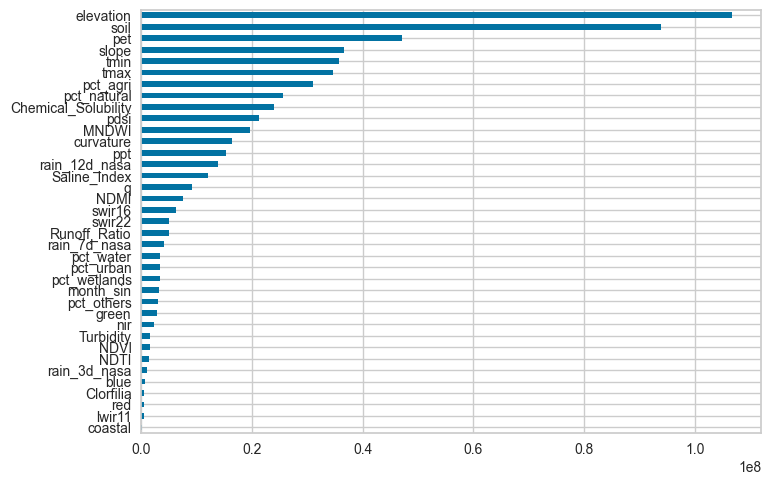

In [10]:
(pd.Series(model_alcalinity.feature_importances_, index = X_train_alkalinity.columns).sort_values().plot.barh())


<Axes: >

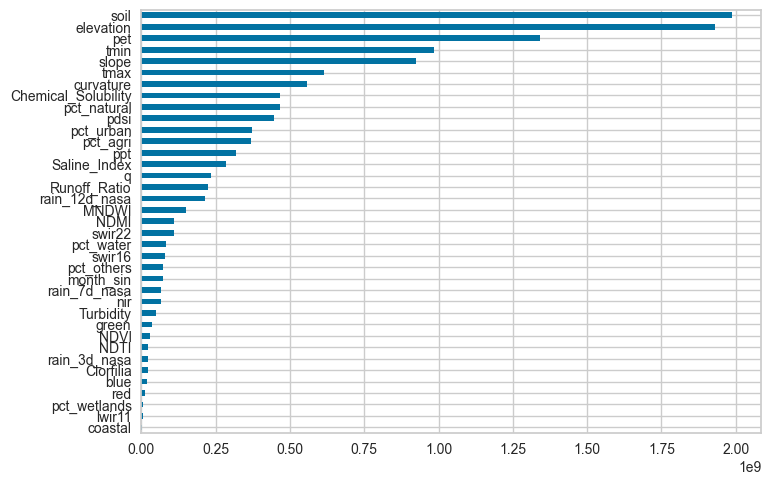

In [11]:

(pd.Series(model_electrical.feature_importances_, index = X_train_electrical.columns).sort_values().plot.barh())


<Axes: >

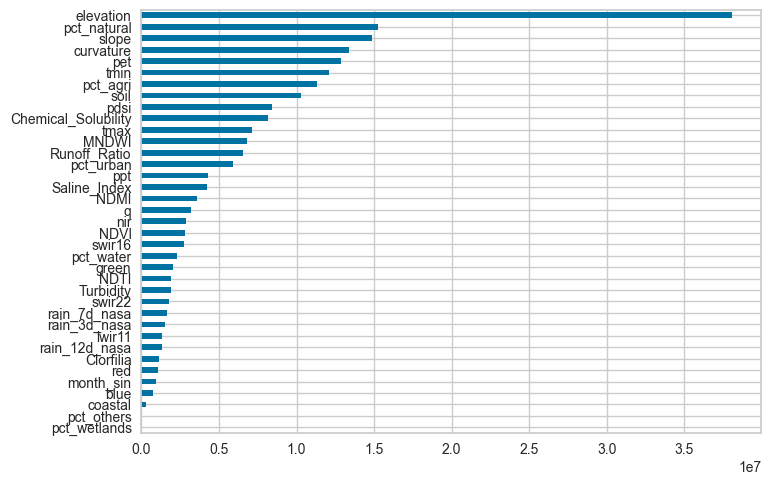

In [12]:

(pd.Series(model_phosphorus.feature_importances_, index = X_train_phosphorus.columns).sort_values().plot.barh())

In [13]:
#make the print in green
print("\033[92mavaliando fosforo\033[0m")
evaluate_model(model_phosphorus.predict(X_train_phosphorus), Y_train_phosphorus, "train evaluation")
evaluate_model(model_phosphorus.predict(X_test_phosphorus), Y_test_phosphorus, "test evaluation")

print()
print("\033[92mavaliando alcalinidade\033[0m")
evaluate_model(model_alcalinity.predict(X_train_alkalinity), Y_train_alkalinity, "train evaluation")
evaluate_model(model_alcalinity.predict(X_test_alkalinity), Y_test_alkalinity, "test evaluation")

print()
print("\033[92mavaliando condutividade eletrica\033[0m")
evaluate_model(model_electrical.predict(X_train_electrical), Y_train_electrical, "train evaluation")
evaluate_model(model_electrical.predict(X_test_electrical), Y_test_electrical, "test evaluation")

avaliando fosforo

train evaluation Evaluation:
R²: 0.721
RMSE: 25.850

test evaluation Evaluation:
R²: -0.053
RMSE: 58.533

avaliando alcalinidade

train evaluation Evaluation:
R²: 0.851
RMSE: 29.067

test evaluation Evaluation:
R²: 0.286
RMSE: 60.040

avaliando condutividade eletrica

train evaluation Evaluation:
R²: 0.850
RMSE: 134.479

test evaluation Evaluation:
R²: 0.175
RMSE: 290.792


(array([230.44045181, 196.34964529, 175.34878686, ..., 614.76853868,
        351.24918917, 780.51725746]),
 0.17508722014208988,
 np.float64(290.7919097168619))

## Submission

In [16]:
submission_csv_files = ['../Datasets/landsat_features_more_bands_validation.csv',
                          '../Datasets/terraclimate_features_more_bands_validation.csv',
                          #'../Datasets/nasa_precip_features_validation.csv',
                          #'../Datasets/soil_use_data_validation.csv',
                          #'../Datasets/nasa_terrain_features_validation.csv'
]

dataHandler.load_submission_data(submission_csv_files)
all_submission_data = dataHandler.get_submission_dataset()

In [17]:

X_pred_input_features = all_submission_data

y_submission_pred_alkalinity = model_alcalinity.predict(X_pred_input_features)
y_submission_pred_electrical = model_electrical.predict(X_pred_input_features)
y_submission_pred_phosphorus = model_phosphorus.predict(X_pred_input_features)

predicted_values_dict = {
    'Total Alkalinity': y_submission_pred_alkalinity, 
    'Electrical Conductance': y_submission_pred_electrical, 
    'Dissolved Reactive Phosphorus': y_submission_pred_phosphorus
}


predicted_pd_final = dataHandler.build_get_submission_dataset(predicted_values_dict)

predicted_pd_final.to_csv("../Results/submission_predictions_boosted_more_data.csv", index=False)


## Averiguando Importância das Features ( sinal ou lixo )

In [18]:


def get_real_signals(model, X_val, y_val, target_name):
    # Calcula a importância por permutação
    result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Cria um DataFrame com os resultados
    perm_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    
    print(f"--- Sinais Reais para {target_name} ---")
    print(perm_df.head(10))
    return perm_df

#alkalinity

signals_alcalinity = get_real_signals(model_alcalinity, X_test_alkalinity, Y_test_alkalinity, "Alkalinity")
signals_alcalinity


--- Sinais Reais para Alkalinity ---
                feature  importance_mean  importance_std
17                 soil         0.205702        0.013880
16                  pet         0.079782        0.004661
15                  ppt         0.041317        0.003359
23  Chemical_Solubility         0.032074        0.003812
3                swir22         0.028382        0.003162
9                 MNDWI         0.025130        0.003641
20                 tmin         0.019277        0.002632
19                 tmax         0.019205        0.001928
8                  NDMI         0.018365        0.002396
14                    q         0.011301        0.001757


,feature,importance_mean,importance_std
17,soil,0.205702,0.013880
16,pet,0.079782,0.004661
15,ppt,0.041317,0.003359
23,Chemical_Solubility,0.032074,0.003812
3,swir22,0.028382,0.003162
9,MNDWI,0.025130,0.003641
20,tmin,0.019277,0.002632
19,tmax,0.019205,0.001928
8,NDMI,0.018365,0.002396
14,q,0.011301,0.001757


In [601]:
# electrical

signals_electrical = get_real_signals(model_electrical, X_test_electrical, Y_test_electrical, "Electrical Conductance")
signals_electrical

--- Sinais Reais para Electrical Conductance ---
         feature  importance_mean  importance_std
17          soil         0.113668        0.013574
29         slope         0.043963        0.004533
20          tmin         0.043900        0.006735
18          pdsi         0.036272        0.002066
16           pet         0.035652        0.005562
9          MNDWI         0.022471        0.001537
15           ppt         0.019917        0.001731
3         swir22         0.016132        0.001225
22  Runoff_Ratio         0.013695        0.002120
21  Saline_Index         0.012490        0.001367


,feature,importance_mean,importance_std
17,soil,0.113668,0.013574
29,slope,0.043963,0.004533
20,tmin,0.043900,0.006735
18,pdsi,0.036272,0.002066
16,pet,0.035652,0.005562
9,MNDWI,0.022471,0.001537
15,ppt,0.019917,0.001731
3,swir22,0.016132,0.001225
22,Runoff_Ratio,0.013695,0.002120
21,Saline_Index,0.012490,0.001367


In [556]:
#phosphorous

signals_phosphorus = get_real_signals(model_phosphorus, X_test_phosphorus, Y_test_phosphorus, "Phosphorus")
signals_phosphorus

--- Sinais Reais para Phosphorus ---
      feature  importance_mean  importance_std
34      slope         0.053665        0.003210
16        pet         0.030853        0.002238
18       pdsi         0.021389        0.002879
20       tmin         0.020022        0.001077
9       MNDWI         0.009114        0.001813
14          q         0.005253        0.000613
17       soil         0.004391        0.003408
19       tmax         0.003842        0.002928
15        ppt         0.003368        0.001194
33  elevation         0.003296        0.007216


,feature,importance_mean,importance_std
34,slope,0.053665,0.003210
16,pet,0.030853,0.002238
18,pdsi,0.021389,0.002879
20,tmin,0.020022,0.001077
9,MNDWI,0.009114,0.001813
14,q,0.005253,0.000613
17,soil,0.004391,0.003408
19,tmax,0.003842,0.002928
15,ppt,0.003368,0.001194
33,elevation,0.003296,0.007216
